In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
import os
import pickle
import datetime
from mix_Network import *

dataset = 'nmnist'
learn_set = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=True,
                                    transform=tonic.transforms.AERtoVector())


records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2021-02-13'
verbose = True

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
krnlinit = 'first'
nblay = 3
nbclust = 4

ds = 3/2
ds = 750
nb_train = int(7500//ds)
nb_test = int(2500//ds)

Using downloaded and verified file: ../Data/nmnist_train.zip
Extracting ../Data/nmnist_train.zip to ../Data/


In [3]:
import time
def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        self.nl = torch.nn.Softmax(dim=1)

    def forward(self, factors):
        return self.nl(self.linear(factors))

In [5]:
34*34*2

2312

In [6]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
num_epochs = 2 ** 9 + 1
# batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_raw_data(dataset, 
            nb_digit,
            learning_rate=learning_rate,
            # batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, #**kwargs
        ):
    

    generator = torch.Generator().manual_seed(42)
    sampler = torch.utils.data.RandomSampler(learn_set, replacement=True, num_samples=nb_digit, generator=generator)
    loader = tonic.datasets.DataLoader(learn_set, sampler=sampler)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')

    N = 34*34*2 # size of the raw NMNIST data
    n_classes = len(dataset.classes)
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    
    for epoch in range(int(num_epochs)):
        losses = []
        for X, label in loader:
            X, label = X.to(device), label.to(device)
            X, label = X.squeeze(0), label.squeeze(0) # just one digit = one batch
            outputs = logistic_model(X)

            n_events = X.shape[0]
            #print(X.squeeze(0).shape, label * torch.ones((1, n_events)))
            #print(outputs, label)
            labels = label*torch.ones(n_events).type(torch.LongTensor)
            labels = torch.nn.functional.one_hot(labels, num_classes=n_classes)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels.type(torch.DoubleTensor))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")
            
    return logistic_model, losses

In [7]:
tic()
model, loss = fit_raw_data(learn_set, 
            nb_train,
            learning_rate=learning_rate,
            # batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=True,
        )
toc()

device -> cpu
Iteration: 0 - Loss: 0.56078
Iteration: 16 - Loss: 0.32700
Iteration: 32 - Loss: 0.22114
Iteration: 48 - Loss: 0.27568
Iteration: 64 - Loss: 0.26045
Iteration: 80 - Loss: 0.16646
Iteration: 96 - Loss: 0.23579
Iteration: 112 - Loss: 0.16835
Iteration: 128 - Loss: 0.47109
Iteration: 144 - Loss: 0.13530
Iteration: 160 - Loss: 0.19964
Iteration: 176 - Loss: 0.31889
Iteration: 192 - Loss: 0.16405
Iteration: 208 - Loss: 0.07553
Iteration: 224 - Loss: 0.28281
Iteration: 240 - Loss: 0.25633
Iteration: 256 - Loss: 0.32321
Iteration: 272 - Loss: 0.15223
Iteration: 288 - Loss: 0.38756
Iteration: 304 - Loss: 0.36044
Iteration: 320 - Loss: 0.13760
Iteration: 336 - Loss: 0.17822
Iteration: 352 - Loss: 0.38696
Iteration: 368 - Loss: 0.15693
Iteration: 384 - Loss: 0.23096
Iteration: 400 - Loss: 0.04270
Iteration: 416 - Loss: 0.23579
Iteration: 432 - Loss: 0.20218
Iteration: 448 - Loss: 0.24385
Iteration: 464 - Loss: 0.43293
Iteration: 480 - Loss: 0.08887
Iteration: 496 - Loss: 0.05608
It

In [8]:
import os
import pickle
f_name = f'{re cords_path}/{dataset}/models/{timestr}_LRmodel_raw.pkl'
with open(f_name, 'wb') as file:
    pickle.dump([model], file, pickle.HIGHEST_PROTOCOL)

In [9]:
tonic.datasets.DataLoader?

Init signature:
tonic.datasets.DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: bool = False,
    sampler: Optional[torch.utils.data.sampler.Sampler[int]] = None,
    batch_sampler: Optional[torch.utils.data.sampler.Sampler[Sequence[int]]] = None,
    num_workers: int = 0,
    collate_fn: Callable[[List[~T]], Any] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Callable[[int], NoneType] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: int = 2,
    persistent_workers: bool = False,
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning.

See :p

In [16]:
test_set = tonic.datasets.NMNIST(save_to='../Data/',
                                train=False,
                                transform=tonic.transforms.AERtoVector())

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [17]:
generator=torch.Generator().manual_seed(42)
sampler = torch.utils.data.RandomSampler(test_set, replacement=True, num_samples=nb_test, generator=generator)
loader = tonic.datasets.DataLoader(test_set, sampler=sampler)

In [18]:
loader.sampler.num_samples

3

In [43]:
loader.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [19]:
for X, label in loader:
    n_events = X.shape[1]
    print(X.squeeze(0).shape, label * torch.ones((1, n_events)).type(torch.LongTensor))

torch.Size([3808, 2312]) tensor([[7, 7, 7,  ..., 7, 7, 7]])
torch.Size([4645, 2312]) tensor([[6, 6, 6,  ..., 6, 6, 6]])
torch.Size([3595, 2312]) tensor([[6, 6, 6,  ..., 6, 6, 6]])


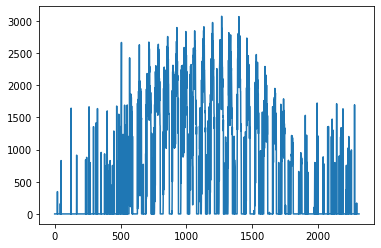

In [20]:
plt.plot(X.sum(axis=(0,1)))

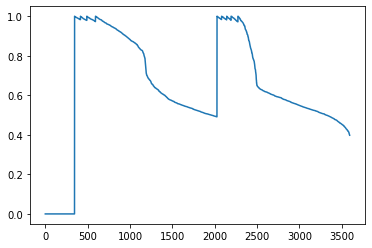

In [21]:
plt.plot(X[0, :, 1203])

In [22]:
test_set = tonic.datasets.NMNIST(save_to='../Data/',
                                train=False,
                                transform=tonic.transforms.AERtoVector())


Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [44]:
def predict_data(test_set, model, # gamma=gamma,
            verbose=False, **kwargs
        ):
    
    with torch.no_grad():

        generator=torch.Generator().manual_seed(42)
        sampler = torch.utils.data.RandomSampler(test_set, replacement=True, num_samples=nb_test, generator=generator)
        loader = tonic.datasets.DataLoader(test_set, sampler=sampler)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        logistic_model = model.to(device)

        pred_target, true_target = [], []

        for X, label in loader:
            X, label = X.to(device), label.to(device)
            X, label = X.squeeze(0), label.squeeze(0)

            n_events = X.shape[0]
            labels = label*torch.ones(n_events).type(torch.LongTensor)

            outputs = logistic_model(X)
            #print(outputs.shape, torch.argmax(outputs, dim=1).shape)

            pred_target.append(torch.argmax(outputs, dim=1).numpy())
            true_target.append(labels.numpy())

    return pred_target, true_target

In [45]:
pred_target, true_target = predict_data(test_set, model)

In [46]:
pred_target, true_target

([array([1, 1, 1, ..., 7, 7, 7]),
  array([1, 1, 7, ..., 6, 6, 6]),
  array([1, 1, 1, ..., 6, 6, 6])],
 [array([7, 7, 7, ..., 7, 7, 7]),
  array([6, 6, 6, ..., 6, 6, 6]),
  array([6, 6, 6, ..., 6, 6, 6])])

In [47]:
for pred_target_, true_target_ in zip(pred_target, true_target):
    print(len(pred_target_), len(true_target_))
    print(len(pred_target_ == true_target_))
    #print(np.mean((pred_target_ == true_target_)*1.))
    print(np.mean(pred_target_ == true_target_))    

3808 3808
3808
0.9884453781512605
4645 4645
4645
0.8693218514531754
3595 3595
3595
0.9899860917941585


In [48]:
accuracy = []
for pred_target_, true_target_ in zip(pred_target, true_target):
    accuracy.append(np.mean(pred_target_ == true_target_))
print(f'{np.mean(accuracy)=}')    

np.mean(accuracy)=0.9492511071328648


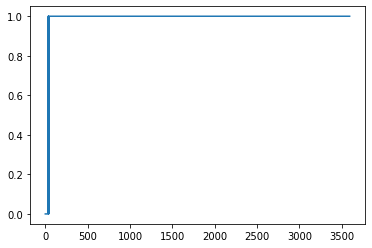

In [49]:
idx = 2
plt.plot(pred_target[idx] == true_target[idx])

# Testing tonic functional aer_to_vect()

In [87]:
from tonic.transforms import AERtoVector

In [88]:
AERtoVector

Init signature: AERtoVector(tau=150000, sample_event=1, sample_space=1, cumulate=False)
Docstring:      Transforms one or more targets into ((N_xgrid * N_ygrid * N_polarities) * N_events) matrices where all events are mapped as a function of their address (column) and indice (line). An exponential decay is applied on their timing. 
File:           ~/quantic/libraries/spikes/tonic/tonic/transforms.py
Type:           type
Subclasses:     


# Using batches

Pour le moment c'est trop long, l'idée était de regrouper différents digits, de faire un shuffle pour que le fit ne se fasse pas sur tout les events d'un digit, puis tous les events de l'autre etc... C'est l'idée du batch mais du coup ça fait des gros batch (environ 4000 x nb_digit au lieu de 256). Je sais pas encore comment faire de petits batchs avec différents digits tout en utilisant le dataloader.  

In [ ]:
f_name = 'lala.pkl'
f_name[:-4]